# B(N)PO :: 3rd iteration of wheeler project for Reacher UnityML environment
---

### 1. Import the Necessary Packages

In [1]:
import torch
from alchemy.agent import Agent, BrainDescription
from alchemy.env import Env

import model

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Load CONFIG :: TODO -> more implicit config

In [2]:
TOTAL_ENV = 20
GOAL_SIZE = 3
STATE_SIZE = 33 - GOAL_SIZE
ACTION_SIZE = 4
N_STEP = 6#10

N_HISTORY = 1#4#
N_ACTORS = 1
MAX_STEPS = 60

DEVICE = "cpu"

### 3. Load Environment

In [3]:
from tasks.uml_reacher_moving_mrocs import StaticReacherProxy, N_REWARDS, f_reward
from utils.task import Task

task = Task(StaticReacherProxy, 30.)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 4. Encoders

In [4]:
from utils.encoders import *
from utils.rnn import FasterGRUEncoder

def Encoder():
    return GlobalNormalizer(STATE_SIZE, N_HISTORY)
    return StackedEncoder(
            GlobalNormalizer(STATE_SIZE, N_HISTORY),
            FasterGRUEncoder(STATE_SIZE, N_HISTORY, 2 * 48, 2))

def GoalEncoder():
    return GoalGlobalNorm(GOAL_SIZE)

encoder = Encoder()
encoder.share_memory()
goal_encoder = GoalEncoder()
goal_encoder.share_memory()

GoalGlobalNorm(
  (norm): Normalizer()
)

### 4. Actor + Critic models

In [5]:
def Actor(encoder, action_size):
    nes_layers = [encoder.out_size() + GOAL_SIZE, 400, 300, action_size]
    return lambda: model.ActorFactory(
        nes_layers, action_size=action_size, 
        f_mean_clip=torch.tanh, f_scale_clip=torch.tanh,
        device=DEVICE)

def Critic(encoder, action_size, n_rewards):
    return lambda: model.Critic(N_ACTORS, n_rewards, encoder.out_size(), action_size)

### 5. Debug out callback, post priting graph + meassuring time

In [6]:
from timebudget import timebudget
try:
    timebudget.set_quiet()
except:
    pass
import time
env_start = time.time()
env_counter = 0
def callback(bot, task, test_scores, learn_scores, seeds, total):
    global env_start, env_counter
    env_counter += 1
    if test_scores is None:
        return
    print("\n\t [", env_counter, "] < %.2f"%(time.time()-env_start), "sec > TEST ==> ", test_scores, "exploring score:", learn_scores.mean())
    timebudget.report("_clocked_step")

### 6. HER implementation ~ buffer specialization

In [7]:
from utils.her import HER, CreditAssignment

import random
class ReacherHER(HER):
    def update_goal(self, rewards, goals, states, states_1, n_goals, n_states, actions, her_step_inds, n_steps):
        MAX_HER_STEP = 1
        gid = 0
        delta = 0
        h_rewards = rewards.clone()
        h_goals = goals.clone()
        h_n_goals = n_goals.clone()
        for i, (g, s, n_g, n, u, step) in enumerate(zip(goals, states, n_goals, n_states, her_step_inds, n_steps)):
            her_active = bool(sum(her_step_inds[(i-MAX_HER_STEP) if MAX_HER_STEP < i else 0:i]))

            if not her_active and u: # we will set-up new goal
                gid = random.randint(0, len(goals[:-self.n_step-MAX_HER_STEP])-1)
                delta = 0

            if her_active or u:
                if gid+delta+self.n_step<len(goals) and i<len(goals)-self.n_step:# previous state was assigned HER
                    g, n_g = goals[gid+delta], goals[gid+delta+step]
                delta += 1

            h_rewards[i] = torch.tensor(f_reward(s, n, g, None, True, None, None))
            h_goals[i] = g.clone()
            h_n_goals[i] = n_g.clone()
        return ( h_rewards, h_goals, states, h_n_goals, n_states )

def ReacherCreditAssignment(cind, gae, n_step, floating_step, gamma, gae_tau, her_delay):
    print("HER IS TURNED OFF!!")
    return CreditAssignment(cind=cind, gae=gae, n_step=n_step, floating_step=floating_step, gamma=gamma, gae_tau=gae_tau)

### 7. Setup agent ( memory + credit assignment + environment and algorithm ~ actor-critic )

In [8]:
from utils.memory import Memory
from utils.memlocal import MemoryBoost

def new_agent(
    her, brains, lr_critic,
    goal_encoder, encoder, freeze_delta, freeze_count, 
    action_size, n_rewards, n_step, max_steps,
    detach_actors, detach_critics, stable_probs,
    good_reach=1, model_path="checkpoints", save=False, load=False,
    eval_delay=20
    ):
    
    credit_assign = [ ReacherHER(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=h) if h else ReacherCreditAssignment(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=None) for i, h in enumerate(her) ]
#        cind = 1, gae=True, n_step=4, floating_step=False, gamma=.99, gae_tau=.95, her_delay=None) for h in her ]

    # g, s, f, a, p, r, n_g, n_s, n_f, c, d
    memory = Memory(20 * max_steps * 200, recalc_delay=3, chunks=[
        GOAL_SIZE, STATE_SIZE, encoder.features_n(), 3*action_size, action_size, 
        n_rewards, GOAL_SIZE, STATE_SIZE, encoder.features_n(), n_rewards, 1], 
                    ep_draw=20, device=DEVICE)

    experience = lambda descs, brain: MemoryBoost(descs, memory, credit_assign, brain, n_step, good_reach)

    agent = Agent(
        DEVICE,
        brains, experience,
        Actor=Actor(encoder, action_size), Critic=Critic(encoder, action_size, n_rewards), 
        goal_encoder=goal_encoder, encoder=encoder, 
        n_agents=1, detach_actors=detach_actors, detach_critics=detach_critics, stable_probs=stable_probs,
        resample_delay=40 * 3, min_step=n_step*2,
        state_size=STATE_SIZE, action_size=action_size,
        freeze_delta=freeze_delta, freeze_count=freeze_count,
        lr_critic=lr_critic, clip_norm=1.,
        model_path=model_path, save=save, load=load, delay=10
    )

    # defined above
    env = Env(agent, 
            total_envs=TOTAL_ENV, n_history=N_HISTORY, history_features=encoder.features_n(), state_size=encoder.in_size(),
            n_step=n_step, send_delta=max_steps,
            eval_limit=10, eval_ratio=.5, max_n_episode=max_steps, eval_delay=eval_delay,
            mcts_random_cap=100000, mcts_rounds=1, mcts_random_ratio=10, limit=2000)
    
    return agent, env

## 8. in depth setup of ALGORITHMs used ( bpo ~> ppo / ddpg / natural )

In [9]:
BS = 256

bpo_brain = [
        
        BrainDescription(
            memory_size=20 * MAX_STEPS * 100, batch_size=BS, 
            optim_pool_size=10*BS, optim_epochs=3, optim_batch_size=2*BS, recalc_delay=2,
            lr_actor=1e-3, learning_delay=40, learning_repeat=7 * 20,
            sync_delta_a=7, sync_delta_c=7, tau_actor=1e-3, tau_critic=1e-3,
            bellman=True, ppo_eps=None, natural=False, mean_only=False, separate_actors=False),

]
print("\nB(N)PO: \n", [b for b in bpo_brain])


B(N)PO: 
 [[120000, '<- memory_size;', 256, '<- batch_size;', 3, '<- optim_epochs;', 512, '<- optim_batch_size;', 2560, '<- optim_pool_size;', 2, '<- recalc_delay;', 7, '<- sync_delta_a;', 7, '<- sync_delta_c;', 40, '<- learning_delay;', 140, '<- learning_repeat;', 0.001, '<- lr_actor;', 0.001, '<- tau_actor;', 0.001, '<- tau_critic;', None, '<- ppo_eps;', False, '<- natural;', False, '<- mean_only;']]


## 9. LEARN!

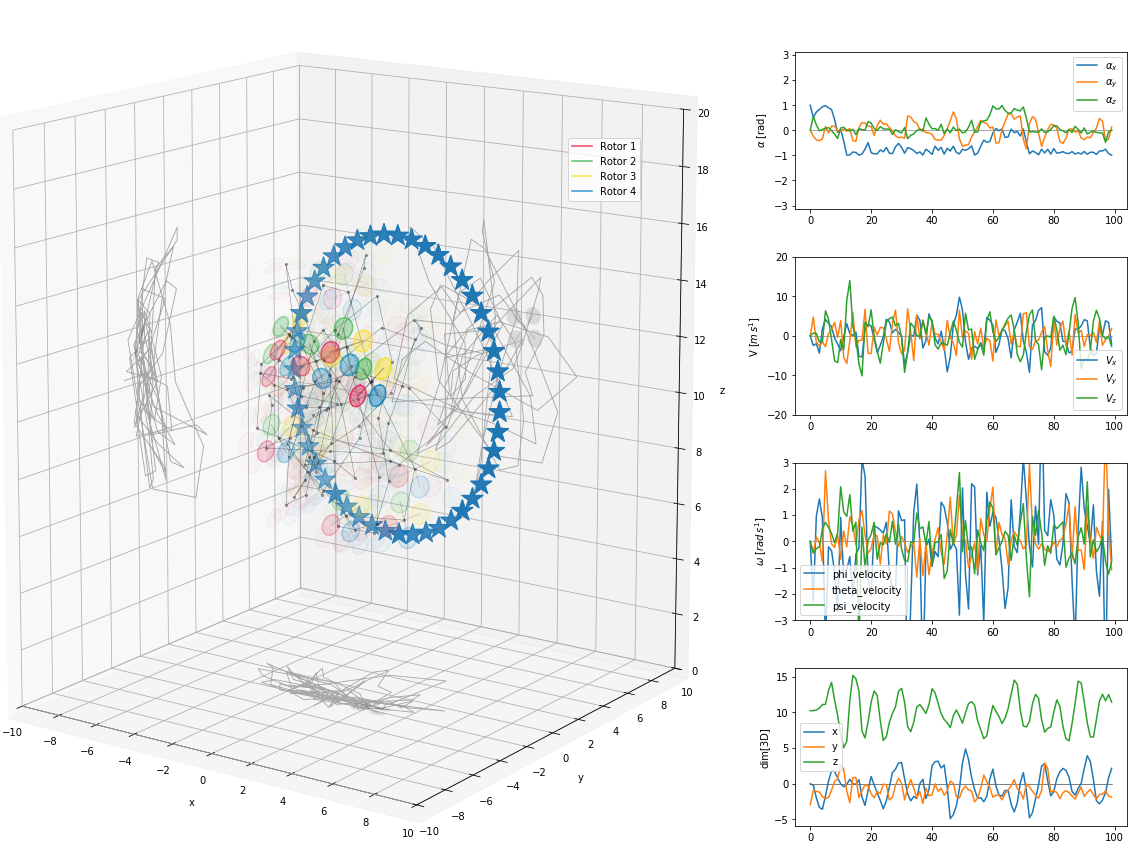

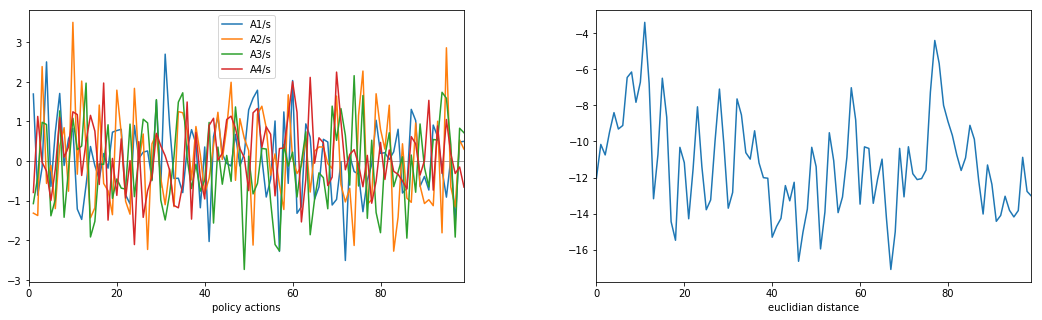

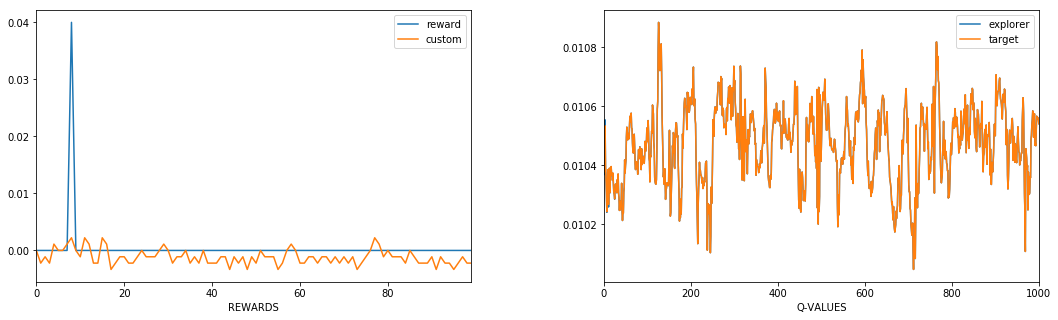

[   19>  1139:: 0] steps =   59, max_step =  60/ 60, reward=-0.026611 <action=tensor([ 0.1555, -0.7669, -1.3143,  0.9025])>                                    
	 [ 19 ] < 378.23 sec > TEST ==>  [[tensor(0.5815)]] exploring score: tensor(-0.0265)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   283.26ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   283.16ms/cyc @     1.1execs/cyc
                    learn: 100.0%   283.12ms/cyc @     1.1execs/cyc
                   _learn:  66.0%   187.00ms/cyc @     2.5execs/cyc
        FastMemory-sample:  58.8%   166.43ms/cyc @     0.7execs/cyc
        FullMemory-sample:  41.2%   116.63ms/cyc @     0.4execs/cyc
                 backprop:  37.7%   106.76ms/cyc @     5.1execs/cyc
            _push_to_fast:  28.0%    79.31ms/cyc @    10.2execs/cyc
                 __call__:   9.0%    25.52ms/cyc @    10.5execs/cyc
                    _push:   1.4%     3.83ms/cyc @     0.3execs/cyc
            credit-assign:   

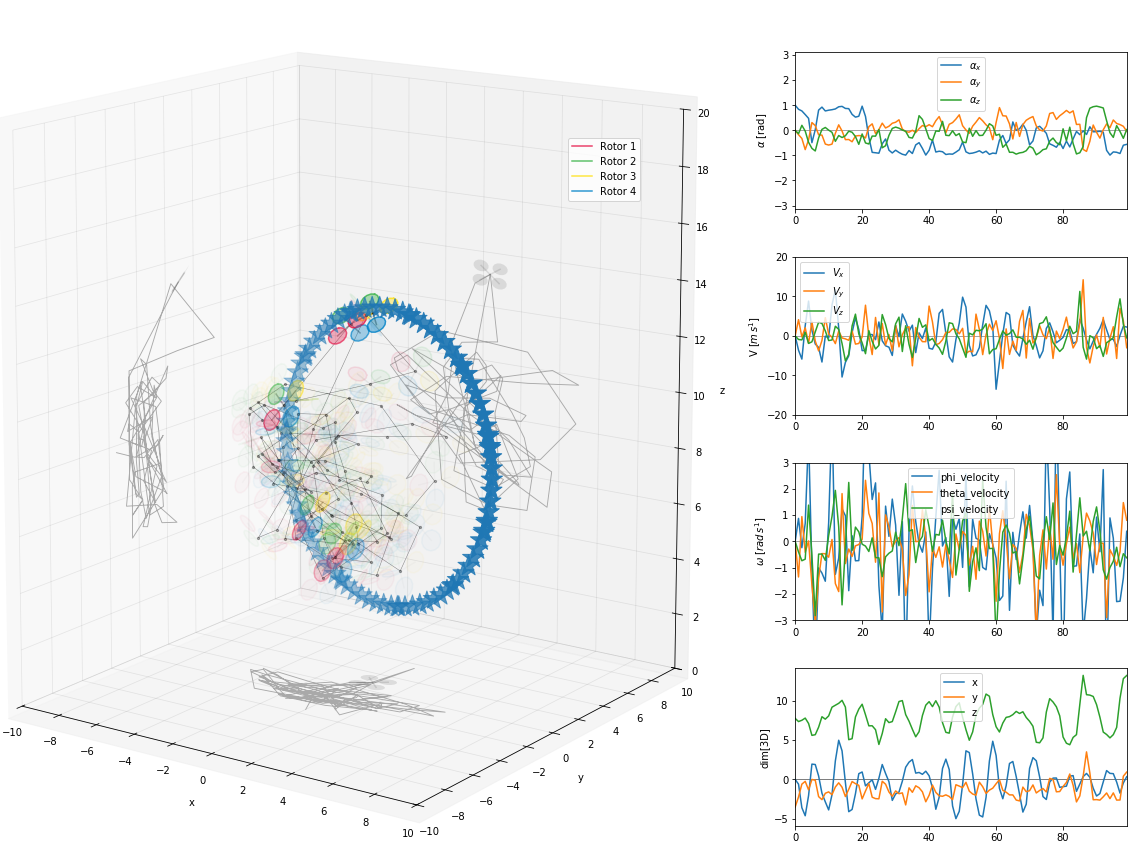

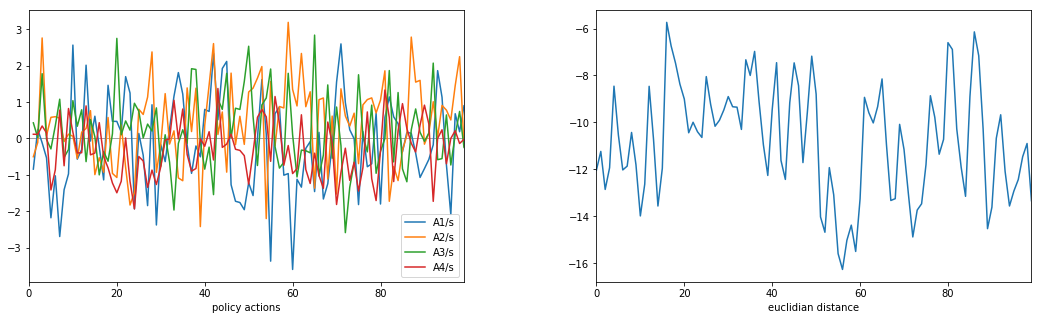

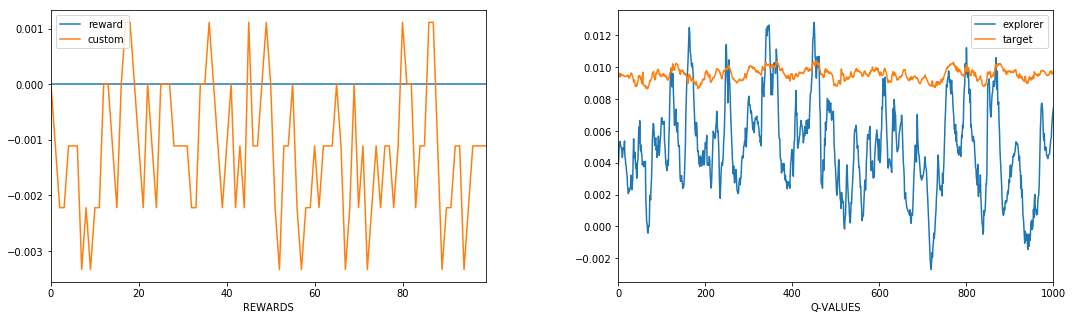

[   39>  2339:: 0] steps =   59, max_step =  60/ 60, reward=-0.021722 <action=tensor([ 0.4159, -3.2515,  0.8554, -1.4681])>                                    
	 [ 39 ] < 778.10 sec > TEST ==>  [[tensor(1.1605)]] exploring score: tensor(-0.0219)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   290.68ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   290.58ms/cyc @     1.1execs/cyc
                    learn: 100.0%   290.54ms/cyc @     1.1execs/cyc
                   _learn:  66.6%   193.57ms/cyc @     2.6execs/cyc
        FastMemory-sample:  59.6%   173.28ms/cyc @     0.8execs/cyc
        FullMemory-sample:  40.3%   117.20ms/cyc @     0.4execs/cyc
                 backprop:  37.9%   110.26ms/cyc @     5.3execs/cyc
            _push_to_fast:  27.5%    79.85ms/cyc @    10.2execs/cyc
                 __call__:   8.8%    25.59ms/cyc @    10.6execs/cyc
                    _push:   1.8%     5.12ms/cyc @     0.3execs/cyc
            credit-assign:   

[  199> 11939:: 0] steps =   59, max_step =  60/ 60, reward=0.034556 <action=tensor([ 0.9432,  2.4893, -0.9342, -1.1395])>                                    
	 [ 199 ] < 4149.11 sec > TEST ==>  [[tensor(3.4640)]] exploring score: tensor(0.0352)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   299.56ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   299.47ms/cyc @     1.1execs/cyc
                    learn: 100.0%   299.43ms/cyc @     1.1execs/cyc
                   _learn:  67.8%   203.18ms/cyc @     2.7execs/cyc
        FastMemory-sample:  60.3%   180.65ms/cyc @     0.8execs/cyc
                 backprop:  41.3%   123.65ms/cyc @     5.3execs/cyc
        FullMemory-sample:  39.6%   118.73ms/cyc @     0.4execs/cyc
            _push_to_fast:  26.6%    79.54ms/cyc @    10.7execs/cyc
                 __call__:   8.4%    25.15ms/cyc @    11.0execs/cyc
                    _push:   6.2%    18.62ms/cyc @     0.3execs/cyc
            credit-assign:   

[  359> 21539:: 0] steps =   59, max_step =  60/ 60, reward=0.049000 <action=tensor([-3.6057, -0.4553,  0.6924,  0.0200])>                                    
	 [ 359 ] < 7558.30 sec > TEST ==>  [[tensor(6.4500)]] exploring score: tensor(0.0507)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   298.54ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   298.45ms/cyc @     1.1execs/cyc
                    learn: 100.0%   298.41ms/cyc @     1.1execs/cyc
                   _learn:  68.7%   205.04ms/cyc @     2.7execs/cyc
        FastMemory-sample:  61.1%   182.50ms/cyc @     0.8execs/cyc
                 backprop:  42.4%   126.60ms/cyc @     5.4execs/cyc
        FullMemory-sample:  38.8%   115.86ms/cyc @     0.4execs/cyc
            _push_to_fast:  25.8%    77.10ms/cyc @    10.6execs/cyc
                 __call__:   8.2%    24.51ms/cyc @    10.9execs/cyc
                    _push:   8.1%    24.14ms/cyc @     0.3execs/cyc
            credit-assign:   

[  519> 31139:: 0] steps =   59, max_step =  60/ 60, reward=0.077222 <action=tensor([-5.2108, -3.2201, -1.2566, -1.2293])>                                    
	 [ 519 ] < 10980.92 sec > TEST ==>  [[tensor(14.0180)]] exploring score: tensor(0.0789)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   298.64ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   298.55ms/cyc @     1.1execs/cyc
                    learn: 100.0%   298.51ms/cyc @     1.1execs/cyc
                   _learn:  69.0%   206.10ms/cyc @     2.7execs/cyc
        FastMemory-sample:  61.4%   183.34ms/cyc @     0.8execs/cyc
                 backprop:  42.9%   128.24ms/cyc @     5.4execs/cyc
        FullMemory-sample:  38.5%   115.12ms/cyc @     0.4execs/cyc
            _push_to_fast:  25.6%    76.33ms/cyc @    10.6execs/cyc
                    _push:   8.8%    26.38ms/cyc @     0.3execs/cyc
                 __call__:   8.1%    24.31ms/cyc @    10.9execs/cyc
            credit-assign: 

[  679> 40739:: 0] steps =   59, max_step =  60/ 60, reward=0.083389 <action=tensor([-3.4212, -3.2333, -1.4530, -0.7863])>                                    
	 [ 679 ] < 14404.82 sec > TEST ==>  [[tensor(18.1670)]] exploring score: tensor(0.0853)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   299.37ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   299.28ms/cyc @     1.1execs/cyc
                    learn: 100.0%   299.24ms/cyc @     1.1execs/cyc
                   _learn:  69.2%   207.02ms/cyc @     2.7execs/cyc
        FastMemory-sample:  61.4%   183.94ms/cyc @     0.8execs/cyc
                 backprop:  43.2%   129.37ms/cyc @     5.4execs/cyc
        FullMemory-sample:  38.5%   115.25ms/cyc @     0.4execs/cyc
            _push_to_fast:  25.5%    76.22ms/cyc @    10.7execs/cyc
                    _push:   9.0%    26.86ms/cyc @     0.3execs/cyc
                 __call__:   8.1%    24.31ms/cyc @    11.0execs/cyc
            credit-assign: 

[  839> 50339:: 0] steps =   59, max_step =  60/ 60, reward=0.126944 <action=tensor([-0.0443, -1.5895, -0.2444,  1.0468])>                                     
	 [ 839 ] < 17837.59 sec > TEST ==>  [[tensor(25.1850)]] exploring score: tensor(0.1299)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   299.77ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   299.68ms/cyc @     1.1execs/cyc
                    learn: 100.0%   299.64ms/cyc @     1.1execs/cyc
                   _learn:  69.3%   207.80ms/cyc @     2.7execs/cyc
        FastMemory-sample:  61.6%   184.61ms/cyc @     0.8execs/cyc
                 backprop:  43.5%   130.29ms/cyc @     5.4execs/cyc
        FullMemory-sample:  38.4%   114.98ms/cyc @     0.4execs/cyc
            _push_to_fast:  25.3%    75.90ms/cyc @    10.7execs/cyc
                    _push:   9.1%    27.40ms/cyc @     0.3execs/cyc
                 __call__:   8.1%    24.22ms/cyc @    11.0execs/cyc
            credit-assign:

[  999> 59939:: 0] steps =   59, max_step =  60/ 60, reward=0.136222 <action=tensor([ 0.7449, -1.2103, -1.3478,  1.3069])>                                
	 [ 999 ] < 21290.58 sec > TEST ==>  [[tensor(24.9940)]] exploring score: tensor(0.1395)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   300.52ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   300.43ms/cyc @     1.1execs/cyc
                    learn: 100.0%   300.40ms/cyc @     1.1execs/cyc
                   _learn:  69.4%   208.48ms/cyc @     2.7execs/cyc
        FastMemory-sample:  61.6%   184.99ms/cyc @     0.8execs/cyc
                 backprop:  43.6%   131.14ms/cyc @     5.4execs/cyc
        FullMemory-sample:  38.4%   115.36ms/cyc @     0.4execs/cyc
            _push_to_fast:  25.3%    75.99ms/cyc @    10.7execs/cyc
                    _push:   9.2%    27.64ms/cyc @     0.3execs/cyc
                 __call__:   8.1%    24.25ms/cyc @    11.0execs/cyc
            credit-assign:   0.

[ 1159> 69539:: 0] steps =   59, max_step =  60/ 60, reward=0.139111 <action=tensor([-1.6115,  0.3678,  0.8878, -0.8791])>                                    
	 [ 1159 ] < 24762.30 sec > TEST ==>  [[tensor(28.8820)]] exploring score: tensor(0.1422)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   301.39ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   301.30ms/cyc @     1.1execs/cyc
                    learn: 100.0%   301.27ms/cyc @     1.1execs/cyc
                   _learn:  69.6%   209.71ms/cyc @     2.7execs/cyc
        FastMemory-sample:  61.8%   186.12ms/cyc @     0.8execs/cyc
                 backprop:  43.9%   132.37ms/cyc @     5.4execs/cyc
        FullMemory-sample:  38.2%   115.10ms/cyc @     0.4execs/cyc
            _push_to_fast:  25.1%    75.68ms/cyc @    10.7execs/cyc
                    _push:   9.2%    27.75ms/cyc @     0.3execs/cyc
                 __call__:   8.0%    24.15ms/cyc @    11.0execs/cyc
            credit-assign:

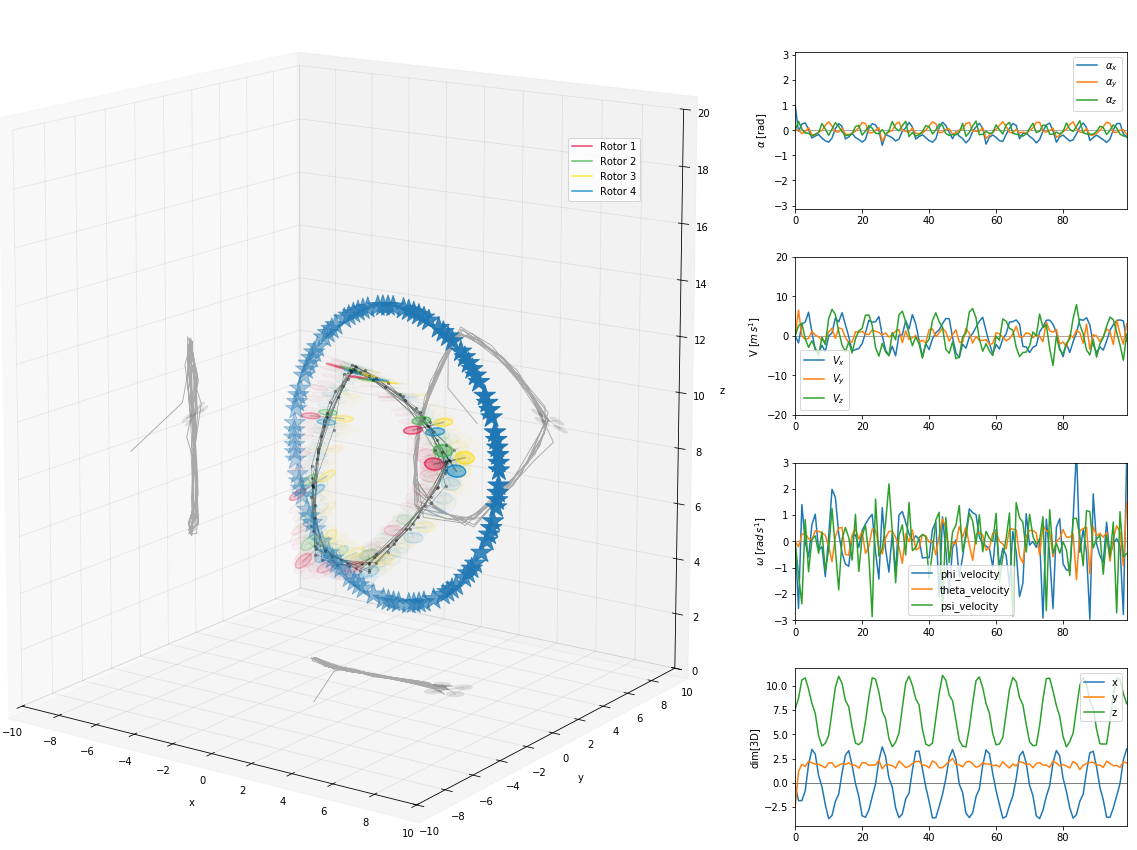

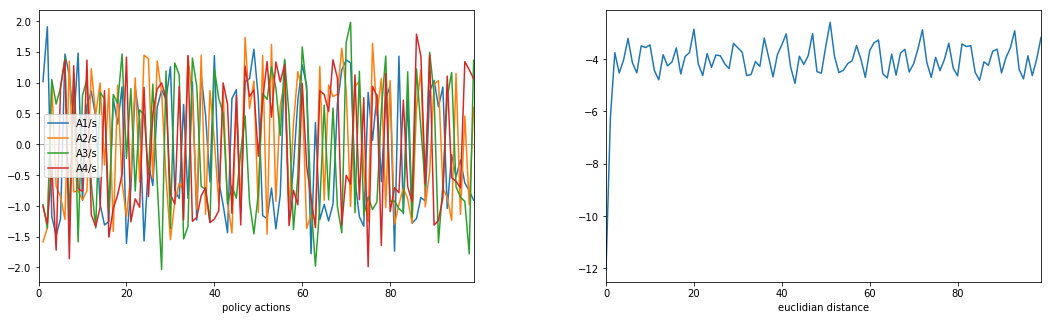

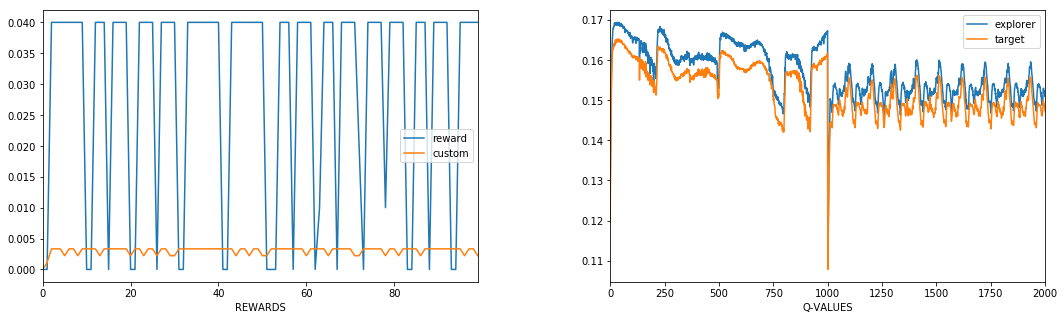

[ 1219> 73139:: 0] steps =   59, max_step =  60/ 60, reward=0.140222 <action=tensor([ 0.6399, -0.8070,  0.6623, -0.5753])>                                     
 environment solved!  30.497299318332217 [array([30.49729932])]
[[tensor(32.3810), tensor(29.8615), tensor(30.3750), tensor(30.6860), tensor(30.3205), tensor(30.3290), tensor(29.9920), tensor(29.6635), tensor(30.7700), tensor(30.5945)]]

	 [ 1219 ] < 26200.26 sec > TEST ==>  [[tensor(32.3810), tensor(29.8615), tensor(30.3750), tensor(30.6860), tensor(30.3205), tensor(30.3290), tensor(29.9920), tensor(29.6635), tensor(30.7700), tensor(30.5945)]] exploring score: tensor(0.1434)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   301.85ms/cyc @     1.0execs/cyc
              learn-round: 100.0%   301.76ms/cyc @     1.1execs/cyc
                    learn: 100.0%   301.72ms/cyc @     1.1execs/cyc
                   _learn:  69.6%   210.11ms/cyc @     2.7execs/cyc
        FastMemory-sample:  61.8%   186.43

In [10]:
agent, env = new_agent(
    [3], bpo_brain, lr_critic=1e-4,
    goal_encoder=goal_encoder, encoder=encoder, freeze_delta=3, freeze_count=3, 
    action_size=4, n_rewards=N_REWARDS, n_step=N_STEP, max_steps=MAX_STEPS,
    detach_actors=False, detach_critics=False, stable_probs=False,
    good_reach=1, model_path="checkpoints", save=True, load=False
    )
scores = env.start(task, callback)

In [11]:
losses = agent.brain.losses
scores_ex = scores[1:]
scores = np.asarray(scores_ex).flatten()
losses_ex = losses
losses = np.vstack(losses_ex)[::len(losses_ex)//200]

### 10. Plot training reward + loss

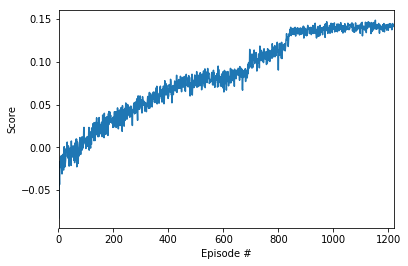

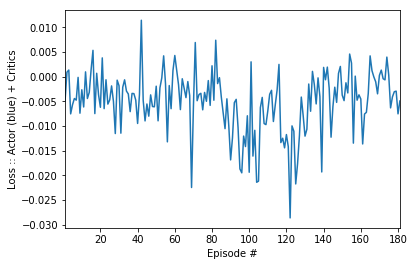

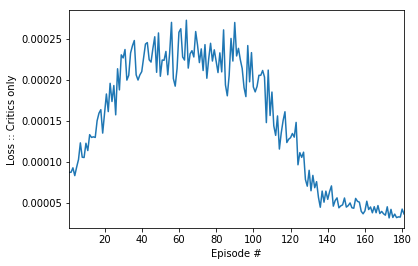

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 0])
plt.ylabel('Loss :: Actor (blue) + Critics')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 1:])
plt.ylabel('Loss :: Critics only')
plt.xlabel('Episode #')
plt.show() 

### 11. Reload trained agent

In [13]:
agent.sync_target(0, [])
agent.sync_explorer(0, [])

### 12. Test visuals - TARGET


 environment solved!  30.86494931011462 [array([30.86494931])]
[[tensor(30.1520), tensor(31.6310), tensor(31.1855), tensor(30.0505), tensor(30.7540), tensor(32.0695), tensor(30.3830), tensor(30.5815), tensor(31.0360), tensor(30.8065)]]

 environment solved!  31.0048493069876 [array([31.00484931])]
[[tensor(30.6910), tensor(31.2550), tensor(31.3675), tensor(29.5855), tensor(31.4600), tensor(30.9045), tensor(30.5840), tensor(31.4925), tensor(31.7260), tensor(30.9825)]]

 environment solved!  30.23924932410008 [array([30.23924932])]
[[tensor(30.5515), tensor(30.3375), tensor(30.9830), tensor(29.9540), tensor(30.0380), tensor(31.1320), tensor(29.7860), tensor(30.2455), tensor(28.6405), tensor(30.7245)]]

 environment solved!  30.39924932052379 [array([30.39924932])]
[[tensor(30.4565), tensor(30.3105), tensor(29.5385), tensor(30.8120), tensor(28.9765), tensor(30.9550), tensor(30.7995), tensor(30.5105), tensor(30.8455), tensor(30.7880)]]

 environment solved!  30.972349307714033 [array([30.

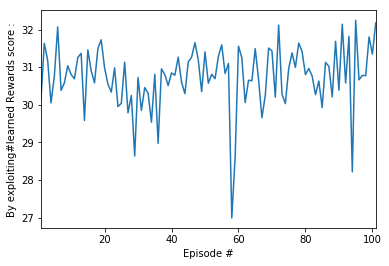

In [16]:
rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate(task)
    [ rewards.extend(score) for i, score in enumerate(scores) ]
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 13. Test visuals - EXPLORER

mean rewards :  28.134764371139


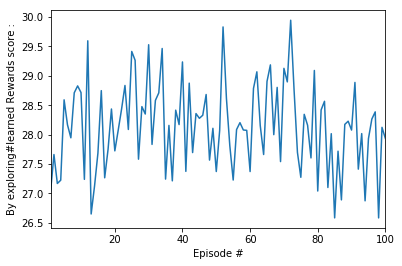

In [17]:
# for evaluation we will set target network to be explorer
agent.brain.ac_target = agent.brain.ac_explorer

rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate(task)
    [ rewards.extend(score) for i, score in enumerate(scores) ]
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By exploring#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()